## Running and analyzing multiple gpmap-based SLiM simulations

Functions for running multiple `GenotypePhenotypeSLiM` simulations under the same parameters and comparing the overall outputs

In [23]:
import gpmap, gpvolve, os, shutil, subprocess
import pandas as pd, numpy as np
from scipy.sparse import dok_matrix

### 1. Generate a rough mount fuji map with 5 sites that can each have 2 states

In [30]:
gpm = gpmap.simulate.generate_gpm(alphabet='01', num_sites=5, num_states_per_site=2)

# generate fuji fitness landscape towards derived state
gpm.data.loc[:, 'fitness'] = gpmap.simulate.fuji(gpm, ref_genotype = '1'*5, roughness = 0.1)
gpm.data.loc[gpm.data.fitness < 0,"fitness"] = 0.0
gpm.data.loc[max(gpm.data.index),"fitness"] = max(gpm.data.fitness)
gpm.get_neighbors()

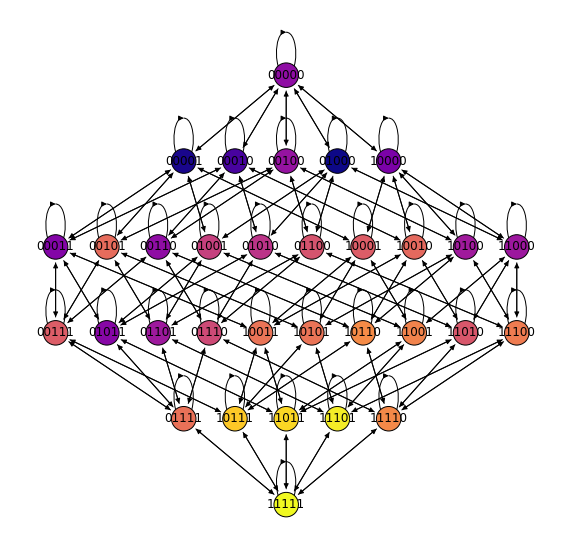

In [31]:
G = gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
G.add_node_cmap(data_column="fitness")
G.add_node_labels(data_column="binary")
G.edge_options["arrows"] = True
G.node_options["node_size"] = 600
_ = gpmap.plot(G,plot_node_labels=True)

### 2. Run with transition path theory

In [32]:
# To calculate T, first get c-friendly representation of neigbors
neighbor_slicer,neighbors = gpvolve.utils.flatten_neighbors(gpm)

# Then calcualte transition matrix given fitness in gpm, neighbors, a fixation model, and a population size
# (fixation_model can be moran, mcclandish, or sswm (strong-selection, weak mutation)). 
T = gpvolve.markov.utils.generate_tmatrix(gpm.fitness,neighbor_slicer,neighbors,
                                          fixation_model="moran",
                                          population_size=10)

print("T is a row-stochastic matrix")
print("T dimensions:",T.shape)
print("column sums:",np.sum(T,axis=0))
print("row sums:",np.sum(T,axis=1))

T is a row-stochastic matrix
T dimensions: (32, 32)
column sums: [1.12955239 0.69058765 0.80231988 0.97454233 0.93308632 1.15931054
 0.90822003 1.02938577 0.6863544  1.15448611 1.11065289 0.83292836
 1.12153482 0.81327507 0.99373293 1.07326003 0.8704638  1.08748383
 1.10551743 1.00831335 0.89501325 0.99128681 1.09205475 1.09056662
 0.951291   1.03364134 0.97905958 1.15467121 1.06452202 1.15641637
 1.01968954 1.08677958]
row sums: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [33]:
print(T.diagonal())

[0.94523262 0.67707992 0.76969493 0.8642253  0.85750143 0.9483507
 0.83347527 0.89919788 0.67488674 0.93964457 0.92961168 0.78704657
 0.93487202 0.77752778 0.89011055 0.91749328 0.81826405 0.91661393
 0.9288888  0.88995309 0.8279683  0.88371106 0.92762442 0.93487596
 0.84807435 0.90141631 0.87845228 0.94974437 0.91537    0.95263572
 0.90322468 0.93488619]


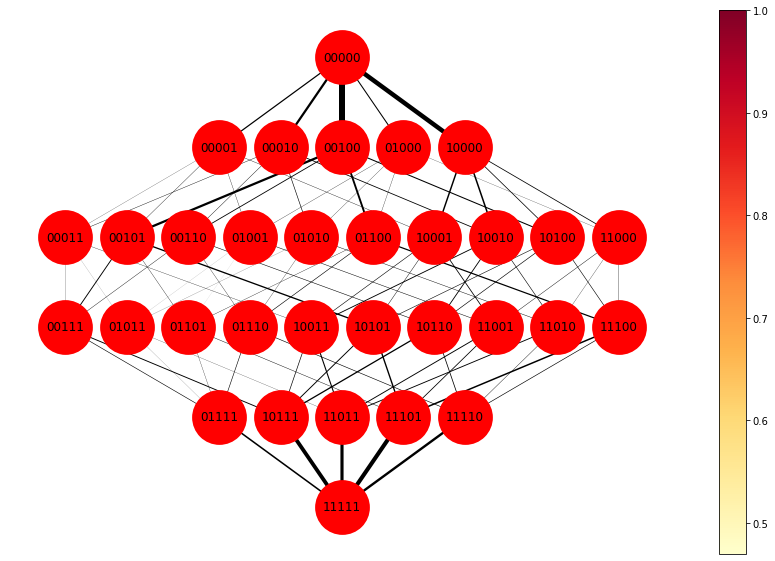

In [36]:
g = gpvolve.markovmodel.GenotypePhenotypeMSM(gpm)
g.transition_matrix = T
flux = gpvolve.flux.TransitionPathTheory(g, [0], [31])
norm_flux = flux.net_flux/flux.total_flux
fig, ax = gpvolve.pyplot.visualization.plot_network(g,
                       flux=dok_matrix(norm_flux), attribute='fitness',
                       colorbar=True, arrows=True)

### 3. Pass gpmap to `run_multiple.py`

`run_multiple.py` is a command-line Python script that runs multiple simulations, saving the edge weights of each unique simulation to a tsv file

In [37]:
N = 500
u = 0.01

# establish multiple-runs directory
if os.path.exists('SLiM_mrs'):
    shutil.rmtree('SLiM_mrs')
os.makedirs('SLiM_mrs')
gpm.to_csv('SLiM_mrs/gpm.txt')

# run_multiple.py
subprocess.run(['python', 'run_multiple.py', 
                '--gpmap','SLiM_mrs/gpm.txt',         # genotype-phenotype map
                '--N',str(N),                         # population size
                '--u',str(u),                         # mutation rate
                '--working_dir','SLiM_mrs/working',   # working directory for SLiM output
                '--slim_out','SLiM_mrs/slim',         # output for SLiM jsons
                '--outpath','SLiM_mrs/out'])          # output for path summary tsv

Traceback (most recent call last):
  File "/Users/clararehmann/phd/research/Harms_R01/SLiM/gpvolve_demo/run_multiple.py", line 98, in <module>
    sim = run_slim(gpm, args.working_dir, args.N, args.u)
  File "/Users/clararehmann/phd/research/Harms_R01/SLiM/gpvolve_demo/run_multiple.py", line 30, in run_slim
    sim.slimulate(N, u, 100000000, working_dir, overwrite=True)
  File "/Users/clararehmann/phd/research/Harms_R01/gpvolve/gpvolve/slimsim.py", line 107, in slimulate
    p.wait()
  File "/Users/clararehmann/miniconda3/envs/py39/lib/python3.9/subprocess.py", line 1189, in wait
    return self._wait(timeout=timeout)
  File "/Users/clararehmann/miniconda3/envs/py39/lib/python3.9/subprocess.py", line 1917, in _wait
    (pid, sts) = self._try_wait(0)
  File "/Users/clararehmann/miniconda3/envs/py39/lib/python3.9/subprocess.py", line 1875, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt


KeyboardInterrupt: 

### 4. Read path summary tsv 

`run_multiple.py` saves the edge weight output of each unique simulation. Average across each edge weight at equilibrium to get an idea of flux...

In [44]:
# read tsv and get edge weights

pathdf = pd.read_csv('SLiM_mrs/out_paths.txt', sep='\t')
slimweights = dict(zip(list(pathdf.columns[2:]), list(pathdf.mean(axis=0, numeric_only=True)[1:]))) # average edge weights over all simulations

gpm.neighbors['slim_weight'] = [0] * len(gpm.neighbors)
for key, value in slimweights.items():
    gpm.neighbors.loc[gpm.neighbors['edge'] ==eval(key), 'slim_weight'] = value

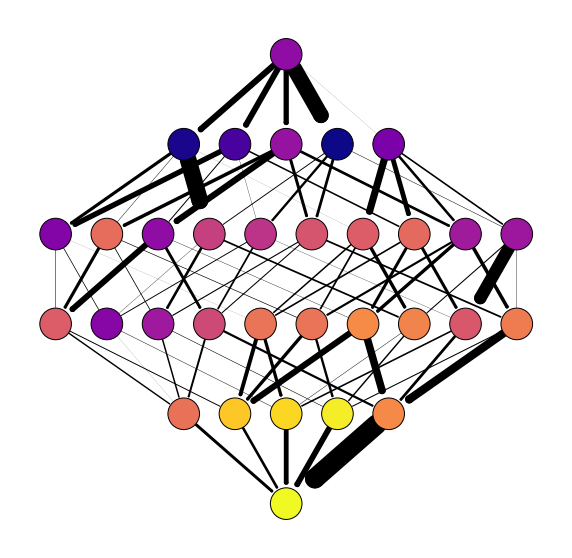

In [39]:
# plot the flux!

G = gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
    
# get rid of self loops
mask = gpm.neighbors.direction != 1
gpm.neighbors.loc[mask, 'include'] = False
    
G.edge_options["arrows"] = None
G.edge_options['arrowsize']=0.001
G.add_edge_sizemap(data_column = 'slim_weight')
G.add_node_cmap(data_column = 'fitness')
g = gpmap.plot(G)

### 5. Compare SLiM and TPT...

In [48]:
from scipy.stats import entropy

# sum path probs across TPT edges
scs = list(gpm.neighbors[gpm.neighbors.direction == 1].source)
tgs = list(gpm.neighbors[gpm.neighbors.direction == 1].target)
pprob = []
for i in range(len(scs)):
    s = scs[i]
    t = tgs[i]
    pprob.append(norm_flux[s, t])
TPTent = entropy(pprob)

# edge fluxes for SLiM
SLiMent = entropy(list(pathdf.mean(axis=0, numeric_only=True)[1:]))

print('Shannon entropy across map using TPT: ', TPTent)
print('Shannon entropy across map using SLiM: ', SLiMent)

Shannon entropy across map using TPT:  3.9637464525601156
Shannon entropy across map using SLiM:  3.8709043542064525


In [49]:
scs = list(gpm.neighbors[gpm.neighbors.direction == 1].source)
tgs = list(gpm.neighbors[gpm.neighbors.direction == 1].target)
pprob = {}
for i in range(len(scs)):
    s = scs[i]
    t = tgs[i]
    pprob.update({(s,t):norm_flux[s, t]})

fx = gpvolve.paths_prob_to_edges_flux(dict(zip([eval(d) for d in df.columns[2:]],list(df.mean(axis=0, numeric_only=True)[1:]))))

In [51]:
def pdist_diff(allp, epip):

    """
    method to compute the difference 
    between two probability distributions
    """

    diffs = []
    for edge in allp.keys():
        diff = allp[edge] - epip[edge]
        diffs.append(abs(diff))

    return sum(diffs)